Type j to use Jacobi´s algorithm or g to use Gauss-Seidel:g
It took: 0.3889222939809163 minutes to run


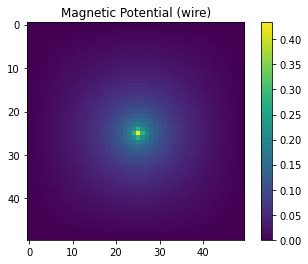

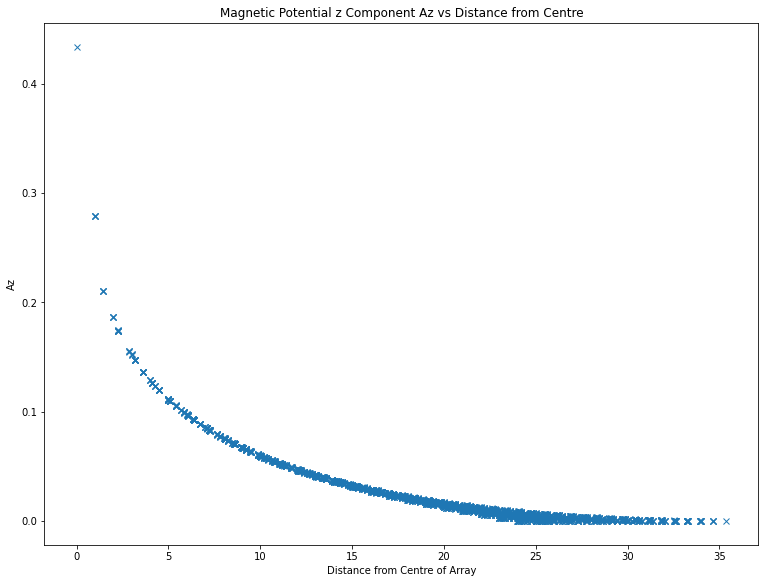

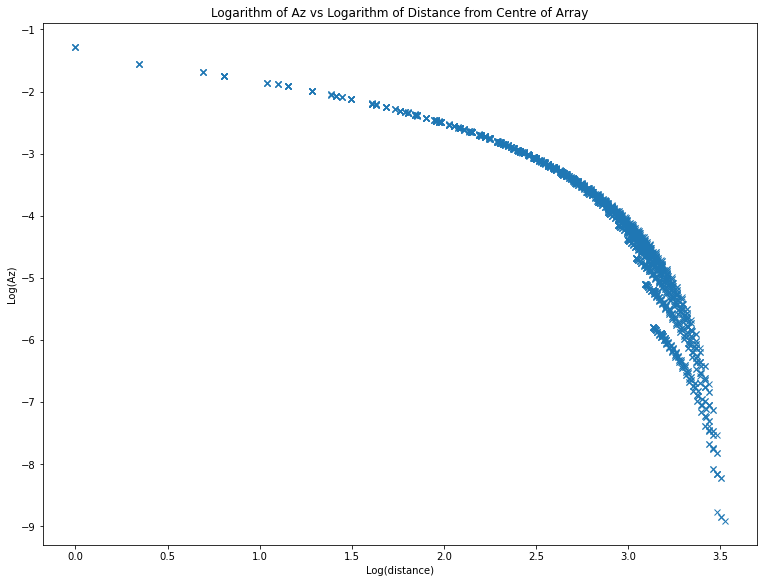

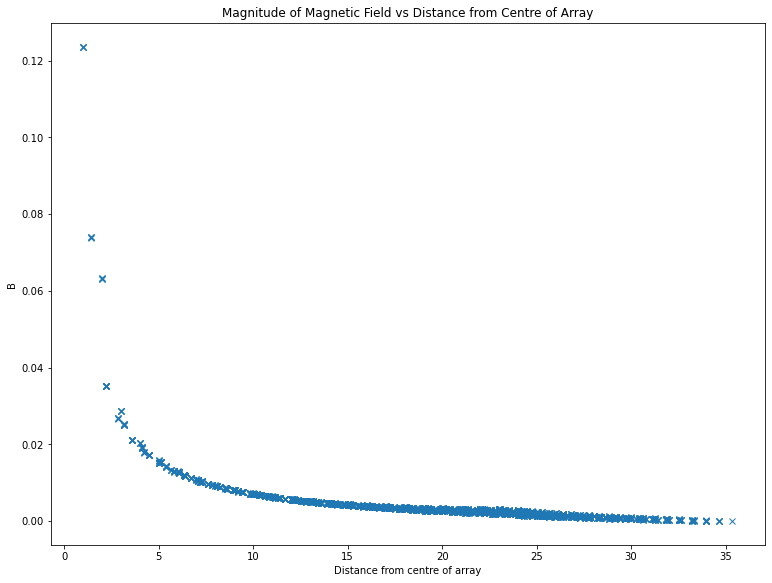

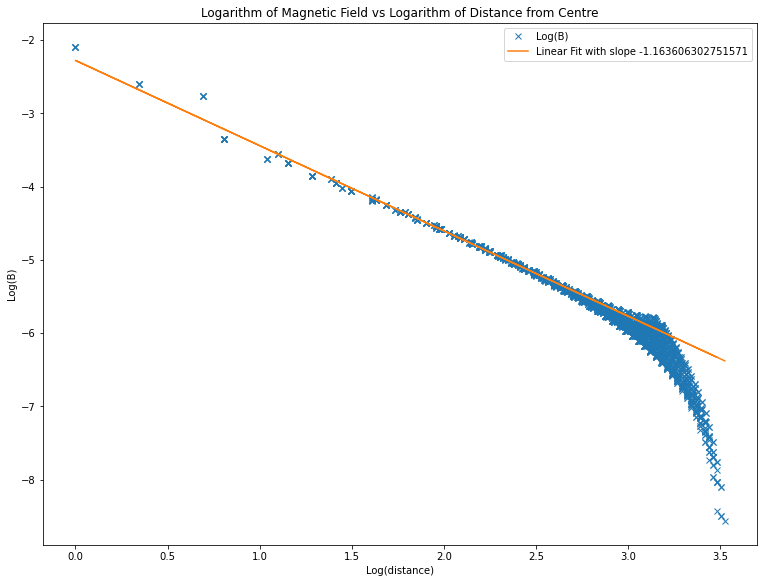

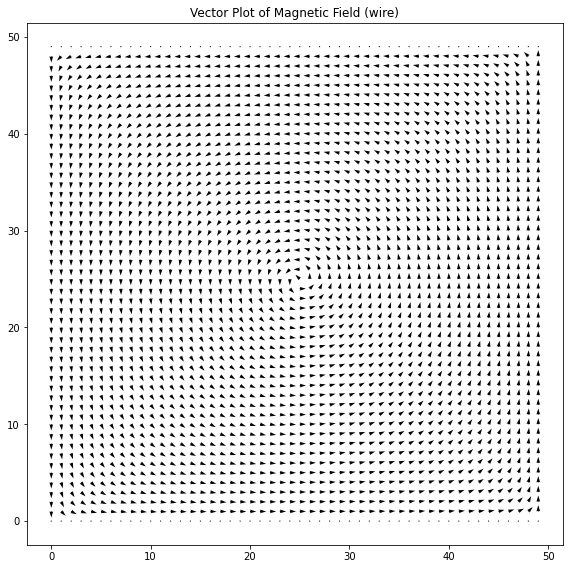

In [1]:
import matplotlib
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import time
import scipy as sp
from scipy import ndimage

start_time=time.time()


#Number of Montecarlo sweeps for calculation
sweeps = 200000


N=50

dt=1
dx=1
M=0.1
a=0.1
k=0.1



def Bfield(phi):
    
    return np.array([(1/(2*dx))*(np.roll(phi,-1,axis=0) - np.roll(phi,1,axis=0)), 
                     (1/(2*dx))*(np.roll(phi,1,axis=1) - np.roll(phi,-1,axis=1))])

def Jacobi(phi):
    
    NewPhi = (1/6)*(np.roll(phi,1,axis=0) + np.roll(phi,-1,axis=0) + np.roll(phi,1,axis=1) + 
                    np.roll(phi,-1,axis=1) + np.roll(phi,1,axis=2) + np.roll(phi,-1,axis=2) + rho)
    
    NewPhi[:,:,N-1] = 0
    NewPhi[:,N-1,:] = 0
    NewPhi[N-1,:,:] = 0
    NewPhi[:,:,0] = 0
    NewPhi[:,0,:] = 0
    NewPhi[0,:,:] = 0
    
    return NewPhi


def GaussSeidel(phi):            
    
    phi2=np.copy(phi)*chessboard1
    phi1=np.copy(phi)*chessboard2
  
    
    phi1 = (1/6)*(np.roll(phi2,1,axis=0) + np.roll(phi2,-1,axis=0) + np.roll(phi2,1,axis=1) 
                  + np.roll(phi2,-1,axis=1) + np.roll(phi2,1,axis=2) + np.roll(phi2,-1,axis=2) + rho*chessboard1)
    
    phi1[:,:,N-1] = 0
    phi1[:,N-1,:] = 0
    phi1[N-1,:,:] = 0
    phi1[:,:,0] = 0
    phi1[:,0,:] = 0
    phi1[0,:,:] = 0
    
    phi =  phi1 + (1/6)*(np.roll(phi1,1,axis=0) + np.roll(phi1,-1,axis=0) + np.roll(phi1,1,axis=1) 
                  + np.roll(phi1,-1,axis=1) + np.roll(phi1,1,axis=2) + np.roll(phi1,-1,axis=2) + rho*chessboard2)
    
    phi[:,:,N-1] = 0
    phi[:,N-1,:] = 0
    phi[N-1,:,:] = 0
    phi[:,:,0] = 0
    phi[:,0,:] = 0
    phi[0,:,:] = 0
    
    return phi 
            
chessboard1 = np.sum(np.indices((N,N,N)),axis=0) % 2
chessboard2 = (np.sum(np.indices((N,N,N)),axis = 0) + np.ones((N,N,N))) % 2

phi = np.zeros((N,N,N))
prevphi = np.zeros((N,N,N))
rho = np.zeros((N,N,N))

for i in range(N):
    rho[int(N/2),int(N/2),i] = 1


algorithm=input("Type j to use Jacobi´s algorithm or g to use Gauss-Seidel:" "")

if algorithm == "j":
    
    for i in range(sweeps):         
        
        phi = Jacobi(phi)
        
        if np.sum(abs(Jacobi(phi)-phi)) < 10**(-3): 
            break

elif algorithm == "g":
    
    for i in range(sweeps):         
     
        phi=GaussSeidel(phi)
    
        if np.sum(abs(prevphi-phi)) < 10**(-3):
            break

        prevphi=np.copy(phi)
else:
    
    print("You did not press k nor g, please try again.")        
        

im=plt.figure()
plt.imshow((phi[:,:,int(N/2)]))
plt.title("Magnetic Potential (wire)")
plt.colorbar()

bx=Bfield(phi)[0]
by=Bfield(phi)[1]


magB=np.sqrt(bx[:,:,int(N/2)]**2 + by[:,:,int(N/2)]**2)

plotphi=[]
plotdistB=[]
plotdist=[]
logplotphi=[]
logplotdist=[]
plotB=[]
logplotB=[]


    
dist=np.zeros((N,N))

for i in range(N):
    for j in range(N):
        dist[i,j]=np.sqrt(abs(int(N/2)-i)**2+abs(int(N/2)-j)**2)
        if dist[i,j] != 0:
            plotdistB.append(dist[i,j])
            plotB.append(magB[i,j])
            if phi[:,:,int(N/2)][i,j] != 0:
                logplotB.append(np.log(magB[i,j]))
                logplotphi.append(np.log(phi[:,:,int(N/2)][i,j]))
                logplotdist.append(np.log(dist[i,j]))
        plotdist.append(np.sqrt(abs(int(N/2)-i)**2+abs(int(N/2)-j)**2))
        plotphi.append(phi[:,:,int(N/2)][i,j])

linearfitB=[]
linearfitBdist=[]

if algorithm == "j":
    
    for i in range(len(logplotB)):
        
        if logplotB[i]>-4.5: 
            
            linearfitB.append(logplotB[i])
            linearfitBdist.append(logplotdist[i]) 

elif algorithm == "g":
    
    for i in range(len(logplotB)):
        
        if logplotB[i]>-5.1:
            
            linearfitB.append(logplotB[i])
            linearfitBdist.append(logplotdist[i])   
else:
    
    print("You did not press k nor g, please try again.")    

data=np.vstack((phi.flatten(),bx.flatten(),by.flatten())).T
dataJacobi=pd.DataFrame(data)
dataJacobi.to_csv("dataBfield"+str(algorithm)+".csv",index=False)

f = plt.figure(figsize=(12.8, 9.6));   
plt.plot(plotdist,plotphi,'x')
plt.title("Magnetic Potential z Component Az vs Distance from Centre")
plt.xlabel("Distance from Centre of Array")
plt.ylabel("Az")

    
g=plt.figure(figsize=(12.8, 9.6));
plt.plot(logplotdist,logplotphi,'x')
plt.title("Logarithm of Az vs Logarithm of Distance from Centre of Array")
plt.xlabel("Log(distance)")
plt.ylabel("Log(Az)")
      
e=plt.figure(figsize=(12.8, 9.6));
plt.plot(plotdistB,plotB,'x')
plt.title("Magnitude of Magnetic Field vs Distance from Centre of Array")
plt.xlabel("Distance from centre of array")
plt.ylabel("B")

linearfitlogB=np.polyfit(linearfitBdist,linearfitB,1)
linelogB=linearfitlogB[0]*np.array(logplotdist)+linearfitlogB[1]


logb,ax = plt.subplots(figsize=(12.8, 9.6));
ax.plot(logplotdist,logplotB,'x',label="Log(B)")
ax.plot(logplotdist,linelogB,label="Linear Fit with slope " + str(linearfitlogB[0]) )
leg = ax.legend()
plt.title("Logarithm of Magnetic Field vs Logarithm of Distance from Centre")
plt.xlabel("Log(distance)")
plt.ylabel("Log(B)")

for i in range(len(np.where(magB==0))):
    magB[np.where(magB==0)[i]]=1
    
v= plt.figure(figsize=(9.6, 9.6));        
xloc=np.arange(N)
yloc=np.arange(N)
plt.quiver(xloc, yloc, bx[:,:,int(N/2)]/magB, by[:,:,int(N/2)]/magB)
plt.title("Vector Plot of Magnetic Field (wire)")


print("It took: "+str((time.time()-start_time)/60)+" minutes to run")